In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
#Read all the words
words = open('C:/Users/pchavan/The Bridge/MLStuff/makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [21]:
len(words)

32033

In [22]:
#build the vocabulary of characters and mapping to/from integers    
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [23]:
#build the dataset

block_size = 3 #how many charaters we are going to use to predict next

def build_dataset(words):
    X, Y = [], []

    for w in words:
        # print(w)

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]    #Crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random 
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [24]:
n_embd = 10     # diamentionality of character embedding vectors
n_hidden = 200  # the number of nurons in the hidden layer of the mlp 

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),                   generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),       generator=g) * (5/3) / ((n_embd * block_size) ** 0.5) #0.2
b1 = torch.randn(n_hidden,                              generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),                 generator=g) * 0.01
b2 = torch.randn(vocab_size,                            generator=g) * 0.01

bngain = torch.ones((1, n_hidden))
bnbias = torch.ones((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
sum(p.nelement() for p in parameters)
for p in parameters:
    p.requires_grad = True

In [28]:
#Optimization

max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator= g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y

    #Forward Pass
    emb = C[Xb] #embed chars to vectors
    embcat = emb.view(emb.shape[0], -1) # concatanate the vectors
    #Linear Layer
    hpreact = embcat @ W1 + b1 # Hidden layer pre-activation ## batch normalization has it's own bias
    #Batchnorm Layer
    #-----------------------------------------------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi  +bnbias #batch normalization

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    #-----------------------------------------------------------------------------------------------------------
    
    #Non Linearity
    h = torch.tanh(hpreact) #hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) #Loss Function
    # print(loss.item())

    #Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 50000 else 0.01 # step learning rate decay
    
    for p in parameters:
        p.data += -lr * p.grad

    #track Stat
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d} / {max_steps : 7d} {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break 

      0 /  100000 3.3267


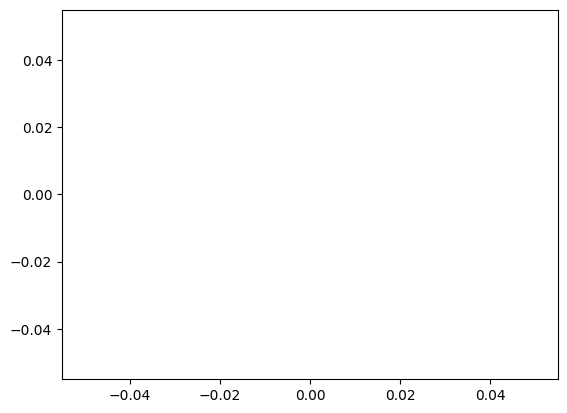

In [12]:
plt.plot(lossi)

In [13]:
#Calibrate batch norm at the end of Training

with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #measure the mean/std over entire training set
    bnmeam = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [14]:
@torch.no_grad()    # this decorator desables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val':(Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, num_hidden)
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias #batch normalization
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias #batch normalization
    h = torch.tanh(hpreact) #N, n_hidden
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)    
    print(loss.item())

split_loss('train')
split_loss('val')

# ver 2 
# 2.2141671180725098
# 2.262075424194336

#Ver3
# 2.0615365505218506
# 2.1102068424224854

#batch_norm
# 2.0923383235931396
# 2.12758731842041

#bn_running
# @torch.no_grad()    # this decorator desables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val':(Xdev, Ydev),
        'test':(Xte, Yte)
    }[split]
    emb = C[x]  # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, num_hidden)
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias #batch normalization
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias #batch normalization
    h = torch.tanh(hpreact) #N, n_hidden
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)    
    print(loss.item())

split_loss('train')
split_loss('val')

# ver 2 
# 2.2141671180725098
# 2.262075424194336

#Ver3
# 2.0615365505218506
# 2.1102068424224854

#batch_norm
# 2.0923383235931396
# 2.12758731842041

#bn_running
# 2.0923383235931396
# 2.12758731842041



3.311413526535034
3.3109118938446045
3.311413526535034
3.3109118938446045


In [15]:
#Sample from model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initalizing with all ...
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples = 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

erquagmyazzszevvndhfyaloqetursjejgrlrg.
ozcjydgeliihsmpqppaledepxvqnwxarqeptzkmhvqrpcn.
szdbvrgxhgmjest.
jcjrwjkjqqxntpucfkubzmgvdtrxyqqufmehgykmejqvskkydmzhjl.
cakyybsufpzbjhlvjurenjcrtvwsvevoecmpfvdxrfqyxoeobhggptixjsfcueywhkhmrjolviilqiiffwvpkxwvlla.
ortabfsztjnegoikvsblitgftxvbssivpu.
meewrkepxcmvyhxavttudkjgczekhgkgtipvtudt.
iwbddihzvorlq.
cjakepxfgniagcrpppfmiipzjgvonxet.
jydnblksqzporygnogsvmwosfzybsyknvmjcxtkncjbmu.
jtew.
aow.
copmplxkkdcqbcep.
ccdfivsnipimhtewmos.
gouwzlrurdckappomtcokwxtnbnzkdphfam.
xcojfffuncxkhosy.
sj.
ascnpc.
cilytanczhndtebimm.
ynw.


In [16]:
#------------------------------SUMMARY--------------------------------#

In [17]:
block_size = 3
class Linear:

    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out), generator = g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = 0
        self.out += x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class Batchmorm1d:

    def __init__(self, dim, eps = 1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        #parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)

    def __call__(self, x):
        #Calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim = True)   #batch mean
            xvar = x.var(0, keepdim = True)     #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)    #normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # Update the buffer 
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_mean + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, *args, **kwds):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
n_embd = 10 #the dimentionality of the character embedding vectors
n_hidden = 100 #the number of nurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)   #for reproducibility

C = torch.randn((vocab_size, n_embd),               generator= g)
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size)
]

with torch.no_grad():
    # Lasr layer : Make less confident
    layers[-1].weight *= 0.1
    # All other layers : Apply again
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) #number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [18]:
# Same optimization as last time
max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]   # batch X, Y

    #forward pass
    emb = C[Xb] #embed chars to vectors
    x = emb.view(emb.shape[0], -1) # concatanate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) #Loss Function
    # print(loss.item())

    #Backward Pass
    for layer in layers:
        layer.out.retain_grad()         #After Debug : would take out retain grad
    for p in parameters:
        p.grad = None
    loss.backward()

    #update 
    lr = 0.1 if i < 50000 else 0.01 # step learning rate decay
    
    for p in parameters:
        p.data += -lr * p.grad

    #track Stat
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d} / {max_steps : 7d} {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break 
    

      0 /  100000 3.2962


In [ ]:
#------------------------------SUMMARY--------------------------------#